In [50]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Flatten, Dense, Reshape, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [18]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [19]:
# Normalize the dataset
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)
# merge test and training
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
del x_test, y_test

In [20]:
print(x_train.shape, y_train.shape)

(70000, 28, 28, 1) (70000,)


In [21]:
# Extract normal (background) digits (excluding digit 5)
normal_digits = np.where(y_train != 5)[0]
anomaly_digits = np.where(y_train == 5)[0]
x_normal = x_train[normal_digits]
x_anomalies = x_train[anomaly_digits]

In [22]:
# Split the normal digits into train, validation, and test sets (50%, 25%, 25%)
x_train_normal, x_temp  = train_test_split(x_normal, test_size=0.5, random_state=42)
x_val_normal, x_test_normal = train_test_split(x_temp, test_size=0.5, random_state=42)

In [23]:
# Combine validation set with anomalies (label 0 for background, 1 for anomalies)
x_val = np.concatenate([x_val_normal, x_anomalies], axis=0)
y_val = np.concatenate([np.zeros(len(x_val_normal)), np.ones(len(x_anomalies))], axis=0)
# shuffle them if you want. Not really needed

In [24]:
print(x_train_normal.shape, x_val_normal.shape, x_test_normal.shape)
print(x_val.shape, y_val.shape)

(31843, 28, 28, 1) (15922, 28, 28, 1) (15922, 28, 28, 1)
(22235, 28, 28, 1) (22235,)


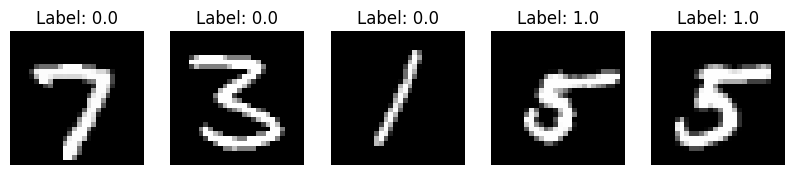

In [25]:
# Visualize some digits from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(x_val[digits[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_val[digits[i]]}")
    ax.axis('off')
plt.show()

In [63]:
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # ----- Encoder -----
    x = Conv2D(1, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    # -> output shape (14, 14, 1)

    # bottleneck
    x = Flatten()(x)
    x = Dense(3, activation ='relu')(x)
    x = Dense(14 * 14 * 1, activation ='relu')(x)
    x = Reshape((14,14,1))(x)

    # ----- Decoder -----
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    # -> output shape (28, 28, 1)

    autoencoder = Model(input_img, decoded)
    return autoencoder

In [64]:
# Build the autoencoder model
input_shape = (28, 28, 1)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           591 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 196)            │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ (None, 14, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 1)      │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,395 (5.45 KB)

 Trainable params: 1,395 (5.45 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Compile the model
autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

In [66]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [67]:
# Train the autoencoder on the training data
history = autoencoder.fit(x_train_normal, x_train_normal,
                          epochs=20,
                          batch_size=64,
                          shuffle=True,
                          validation_data=(x_val_normal, x_val_normal),
                          callbacks=[early_stopping])

Epoch 1/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1209 - val_loss: 0.0667
Epoch 2/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0645 - val_loss: 0.0601
Epoch 3/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0595 - val_loss: 0.0582
Epoch 4/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0580 - val_loss: 0.0575
Epoch 5/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0575 - val_loss: 0.0563
Epoch 6/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0562 - val_loss: 0.0557
Epoch 7/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0557 - val_loss: 0.0553
Epoch 8/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0553 - val_loss: 0.0547
Epoch 9/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0545 - val_loss: 0.0542
Epoch 10/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0545 - val_loss: 0.0538
Epoch 11/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0540 - val_loss: 0.0533
Epoch 12/20
498/498 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

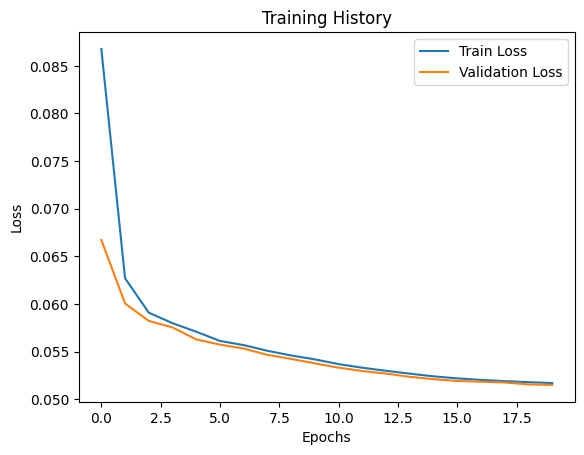

In [68]:
# Plot the training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
# Calculate MSE for the validation dataset
x_out_val = autoencoder.predict(x_val)
mse_val = np.mean(np.square(x_val - x_out_val), axis=(1, 2, 3))

695/695 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step


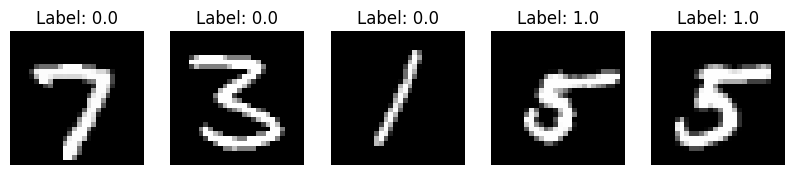

In [70]:
# Visualize some digits from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(x_val[digits[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_val[digits[i]]}")
    ax.axis('off')
plt.show()

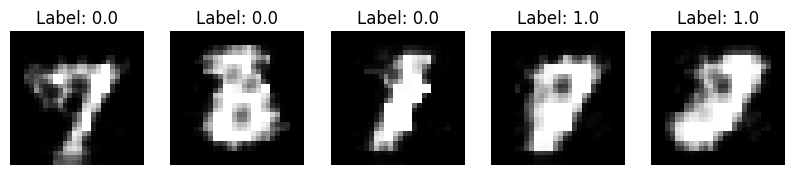

In [71]:
# Visualize some digits from the output dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(x_out_val[digits[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_val[digits[i]]}")
    ax.axis('off')
plt.show()

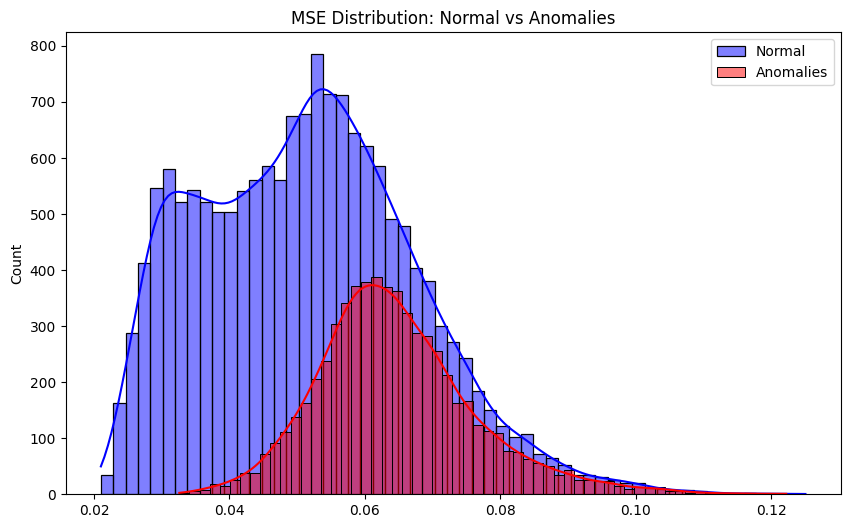

In [72]:
# Plot the distribution of MSE for normal vs anomalies
plt.figure(figsize=(10,6))
sns.histplot(mse_val[y_val == 0], label='Normal', color='blue', kde=True)
sns.histplot(mse_val[y_val == 1], label='Anomalies', color='red', kde=True)
plt.title('MSE Distribution: Normal vs Anomalies')
plt.legend()
plt.show()

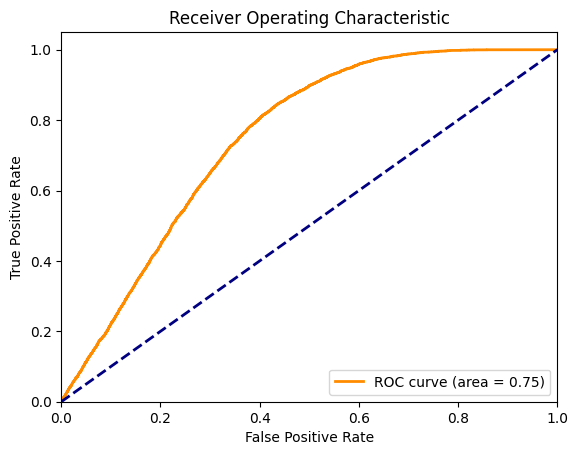

In [73]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_val, mse_val)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# If you want to try a VAE

You need to define a custom loss, sum of the reco loss (here MSE) and the KLD term

You need to modify the encoder so that it has 2k outout for k latent dimensions

You need to sample the z


In [ ]:
# build the encoder
encoder_inputs = Input(shape=(28, 28, 1))
latent_dim = ...

... 

# Latent variables
z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


In [ ]:
# build the decoder
latent_inputs = Input(shape=(latent_dim,))
x = .... (latent_inputs)
decoder_outputs = ... (x)

decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


In [ ]:
# Build  the VAE
z_mean, z_log_var, z = encoder(encoder_inputs)
reconstructed = decoder(z)
vae = models.Model(encoder_inputs, reconstructed, name="vae")

In [74]:
def vae_loss_mse(inputs, outputs, z_mean, z_log_var):
    # Reconstruction loss (MSE)
    reconstruction_loss = tf.keras.losses.mse(
        K.flatten(inputs),
        K.flatten(outputs)
    )
    reconstruction_loss *= 28 * 28  # scale up to image size

    # KL divergence loss
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    # Total loss
    total_loss = K.mean(reconstruction_loss + kl_loss)
    return total_loss

In [ ]:
vae.compile(
    optimizer='adam',
    loss=lambda x, y: vae_loss_mse(x, y, z_mean, z_log_var)
)

In [ ]:
# Train the VAE model
vae.fit(x_train_normal, x_train_normal,
        epochs=50,
        batch_size=128,
        shuffle=True,
        validation_data=(x_val_normal, x_val_normal),
        callbacks=[early_stopping])